In [14]:
import matplotlib.pyplot as plt
import numpy as np
import time

import gymnasium as gym
from gymnasium import spaces
import stable_baselines3 as sb

# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_checker import check_env

In [15]:
def RK4(fun, x, dt, t = 0, a = 0):

    k1 = fun(t,      x,         a)
    k2 = fun(t+dt/2, x+dt*k1/2, a)
    k3 = fun(t+dt/2, x+dt*k2/2, a)
    k4 = fun(t+dt,   x+dt*k3,   a)

    y = x + dt/6*(k1+2*k2+2*k3+k4)
    return y

# Todo esto deberia ir dentro del Env eventualmente

gamma     = .1
gammath   = .1
L     = .2
G     = .98

def cart_evol(t, x, a = 0):
    vDot = a - gamma * x[1]
    xDot = x[1]
    return np.array([xDot, vDot])

def pend_evol(t, x, a = 0):
    thDotDot = (a * np.cos(x[0]) - G * np.sin(x[0]))/L - gammath * x[1]
    thDot    = x[1]
    return np.array([thDot, thDotDot])

def get_pos_pend(ang, x, L):
    return x - L*np.sin(ang), L*np.cos(ang)

def observations(x,th,xDot,thDot):
    return np.array([x, np.cos(th), np.sin(th), xDot/2, thDot/20]).astype(np.float32)

8.729499999999883


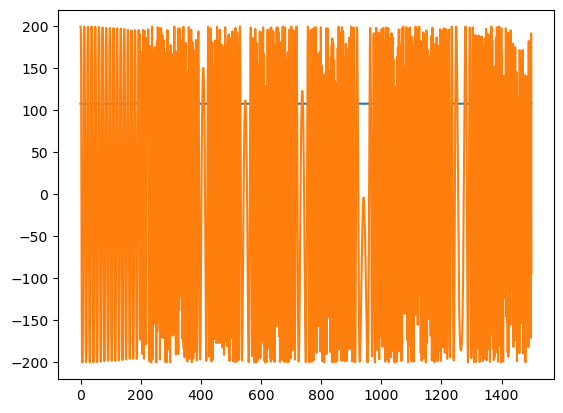

In [16]:
''''
Cambios respecto a la version jugable
  - Adios elementos visuales
  - dt fijo en 8.5ms ~ dt para 120 fps
  - tecnicamente el eje Y apunta hacia abajo y el carro esta en 0 de y
  - puse una listita y un plot para ver q ande bien sin los elementos visuales
'''
crashed = []
ypendlist = []
vlist = []
thvlist = []

rail_lengh = 1500
dt = 8.5/1000 # 8.5ms
target_th = 1
target_H = l*np.cos(target_th)
score = 0

actions = [-1,0,1]
th, thDot  = 0, 0
a, v, x = 0, 0, 0
pend_pos = get_pos_pend(th, x, l)
# Añado esto para poder tratar mejor las colisiones en los bordes
a_pend = a

action = 2
step = 0
while step < 1500: # unos 15s 
  if x < 100:
    crashed.append(-1)
    x, a = 100, -v/dt * .2
    a_pend = -v/dt * 1.2
    v = 0
  elif x > 1400:
    crashed.append(1)
    x, a = 1400, -v/dt * .2
    a_pend = -v/dt * 1.2
    v = 0
  else:
    crashed.append(0)
    a = actions[action] * 1000
    a_pend = a

  x, v = RK4(cart_evol, [x, v], dt, a = a)
  th, thDot = RK4(pend_evol, [th, thDot], dt, a = a_pend)
  
  pend_pos = get_pos_pend(th, x, l)
  ypendlist.append(pend_pos[1])
  vlist.append(v)
  thvlist.append(th)

  if pend_pos[1] < target_H:
    score += dt
  
  step += 1

print(score)
plt.plot([target_H]*1500)
plt.plot(ypendlist)
# plt.plot(vlist)
# plt.plot(thvlist)

In [49]:
from gymnasium import spaces

class Pendulo(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple env where the agent must learn to go always left. 
    """
    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['console']}
    # Define constants for clearer code
    # Distancias en mm?

    def __init__(self, fps = 120, target_th = 1, max_steps = 2000):
        super(Pendulo, self).__init__()

        # Size of the 1D-grid
        self.rail_lengh = 1

        # (x,th), (xDot,thDot)
        self.agent_vars = np.array(((0.,0.),(0.,0.)))

        # variables de tiempo
        self.n_step = 0
        self.max_steps = max_steps
        self.dt      = 1/fps # timestep en seg

        # threshold del reward
        self.targetH = np.cos(target_th)

        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions, we have 3: left, right and still
        self.n_actions = 3
        self.action_space = spaces.Discrete(self.n_actions)
        # The observation will be the coordinate of the agent
        # (x, v, cos th, sin th, thDot)
        # elijo pasarle seno y coseno enves del angulo xq quedan en [-1,1]
        # y no tienen el problema de discontinuidad de th en [-pi,pi]
        self.observation_space = spaces.Box(low = -1, high = 1,
                                            shape=(5,), dtype=np.float32)

    def reset(self, seed = None,):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        super().reset(seed=seed)
        # Initialize the agent at the right of the grid
        self.agent_vars = np.array(((0.,0.),(0.,0.)))
        # here we convert to float32 to make it more general (in case we want to use continuous actions)
        return observations(*np.ravel(self.agent_vars)), {}

    def step(self, action):

        x,v = self.agent_vars[0]
        th,thDot = self.agent_vars[1]

        if action > self.n_actions:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        elif abs(x) > 1:
            x = np.clip(x, -1, 1)
            a = -v/self.dt * .2
            thDotDot = -v/self.dt * 1.2
            v = 0
        else:
            thDotDot = a = action - 1

        x, v = RK4(cart_evol, [x, v], self.dt, a = a)
        th, thDot = RK4(pend_evol, [th, thDot], self.dt, a = thDotDot)

        # print(x,v,th,thDot)

        self.agent_vars = np.array(((x,th),(v,thDot)))

        terminated = False
        if self.n_step >= 1500:
            truncated = True
        else: truncated = False
        # Null reward everywhere except when reaching the goal (left of the grid)
        reward = 1 if np.cos(th) < self.targetH else 0
        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return observations(*np.ravel(self.agent_vars)),\
                reward, terminated, truncated, info

    def render(self, mode='console'):
        # if mode != 'console':
        #     # agent is represented as a cross, rest as a dot
        #     print("." * self.agent_pos, end="")
        #     print("x", end="")
        #     print("." * (self.grid_size - self.agent_pos))
        # else:
            raise NotImplementedError()

    def close(self):
        pass

In [115]:
env = Pendulo()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)


obs_list = [[],[],[],[],[]]
reward_list = []
obs = env.reset()[0]

print(env.observation_space)
print(env.action_space)
print('obs=', obs)

n_steps = 2000
for step in range(n_steps):

  obs, reward, terminated, truncated, info = env.step(0)

  for n in range(5):
    obs_list[n].append(obs[n])
  reward_list.append(reward)

  if terminated:
    print("Goal reached!", "reward=", reward)
    break

Box(-1.0, 1.0, (5,), float32)
Discrete(3)
obs= [0. 1. 0. 0. 0.]


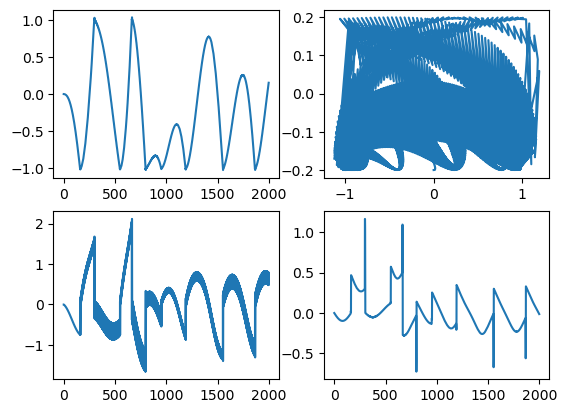

In [116]:
x,costh,sinth,v,thDot = np.array(obs_list)

fig, ax = plt.subplots(2,2)

ax[0,0].plot(x)
ax[0,1].plot(x - .2*sinth, - .2*costh)
ax[1,0].plot(v)
ax[1,1].plot(thDot)

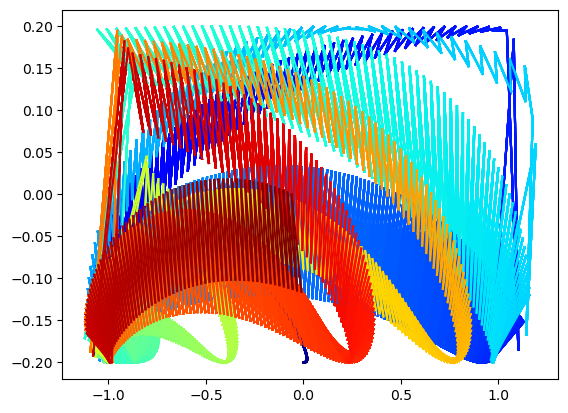

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from cycler import cycler

xx = x - .2*sinth
yy = - .2*costh

MAP = 'jet'
NPOINTS = len(xx)

fig = plt.figure()
ax1 = fig.add_subplot(111) 
cm = plt.get_cmap(MAP)
for i in range(10):
    colors = [cm(1.0*i/(NPOINTS-1)) for i in range(NPOINTS-1)]
    ax1.set_prop_cycle(cycler('color', colors))
    for i in range(NPOINTS-1):
        plt.plot(xx[i:i+2],yy[i:i+2])

# plt.title('Inner minimization', fontsize=25)
# plt.xlabel(r'Friction torque $[Nm]$', fontsize=25)
# plt.ylabel(r'Accelerations energy $[\frac{Nm}{s^2}]$', fontsize=25)
plt.show() # Show the figure

MovieWriter ffmpeg unavailable; using Pillow instead.


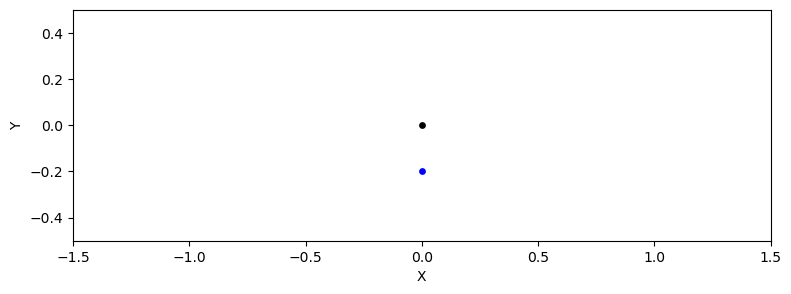

In [120]:
from matplotlib import animation

fig, ax = plt.subplots(figsize = (9,3), dpi = 100)

x1 = x
zz = np.zeros(len(x))
xx = x - .2*sinth
yy = - .2*costh

# x1 = x1[::10]
# zz = zz[::10]
# xx = xx[::10]
# yy = yy[::10]

scat = ax.scatter(xx[0], yy[0], c="b", s=15)
scat2 = ax.scatter(x[0], zz[0], c="k", s=15)

ax.set(xlim=[-1.5, 1.5], ylim=[-.5, .5], xlabel='X', ylabel='Y')


def update(frame):
    # for each frame, update the data stored on each artist.
    x = x1[frame]
    z = zz[frame]
    X = xx[frame]
    Y = yy[frame]
    # update the scatter plot:
    data = np.stack([X, Y]).T
    data2 = np.stack([x, z]).T
    scat.set_offsets(data)
    scat2.set_offsets(data2)
    # update the line plot:
    return scat


ani = animation.FuncAnimation(fig=fig, func=update, frames=len(xx), interval = .001)
ani.save("mov.gif")